# Import Libraries:

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from numpy.linalg import norm
from scipy.sparse import hstack
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import distance
from wordcloud import WordCloud
import pickle
from sklearn.neighbors import NearestNeighbors

# stop_words = set(stopwords.words("english"))

In [2]:
data = pd.read_json('tops_fashion.json')

In [3]:
print('The shape of dataset is:',data.shape)
data.head(5)

The shape of dataset is: (183138, 19)


sku        asin product_type_name formatted_price author  \
0  None  B016I2TS4W             SHIRT            None   None   
1  None  B01N49AI08             SHIRT            None   None   
2  None  B01JDPCOHO             SHIRT            None   None   
3  None  B01N19U5H5             SHIRT            None   None   
4  None  B004GSI2OS             SHIRT          $26.26   None   

               color         brand publisher  \
0               None         FNC7C      None   
1               None  FIG Clothing      None   
2               None  FIG Clothing      None   
3               None       Focal18      None   
4  Onyx Black/ Stone   FeatherLite      None   

                          availability  \
0                                 None   
1                                 None   
2                                 None   
3                                 None   
4  Usually ships in 6-10 business days   

                                             reviews  \
0  [False, https://www.amazon.com/reviews/iframe?...   
1  [False, https://www.amazon.com/reviews/iframe?...   
2  [False, https://www.amazon.com/reviews/iframe?...   
3  [True, https://www.amazon.com/reviews/iframe?a...   
4  [False, https://www.amazon.com/reviews/iframe?...   

                                     large_image_url availability_type  \
0  https://images-na.ssl-images-amazon.com/images...              None   
1  https://images-na.ssl-images-amazon.com/images...              None   
2  https://images-na.ssl-images-amazon.com/images...              None   
3  https://images-na.ssl-images-amazon.com/images...              None   
4  https://images-na.ssl-images-amazon.com/images...               now   

                                     small_image_url  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   
3  https://images-na.ssl-images-amazon.com/images...   
4  https://images-na.ssl-images-amazon.com/images...   

                                    editorial_review  \
0  Minions Como Superheroes Ironman Women's O Nec...   
1  Sizing runs on the small side. FIG® recommends...   
2  Sizing runs on the small side. FIG® recommends...   
3  100% Brand New & Fashion<br> Quantity: 1 Piece...   
4                                                      

                                               title model  \
0  Minions Como Superheroes Ironman Long Sleeve R...  None   
1                      FIG Clothing Womens Izo Tunic  None   
2                        FIG Clothing Womens Won Top  None   
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...  None   
4  Featherlite Ladies' Long Sleeve Stain Resistan...  None   

                                    medium_image_url manufacturer  \
0  https://images-na.ssl-images-amazon.com/images...         None   
1  https://images-na.ssl-images-amazon.com/images...         None   
2  https://images-na.ssl-images-amazon.com/images...         None   
3  https://images-na.ssl-images-amazon.com/images...         None   
4  https://images-na.ssl-images-amazon.com/images...         None   

  editorial_reivew  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

- We can see there are a lot of 'None' for many features. So we will be dropping these features and others which seem like, they won't contribute much in our recommendation task.

In [4]:
# Dropping the unnecessary features and keeping the required one's:

data = data[['asin','product_type_name','formatted_price','color','brand','title','medium_image_url']]
print('Current shape of our dataset:',data.shape)

Current shape of our dataset: (183138, 7)


In [5]:
data.head(2)

asin product_type_name formatted_price color         brand  \
0  B016I2TS4W             SHIRT            None  None         FNC7C   
1  B01N49AI08             SHIRT            None  None  FIG Clothing   

                                               title  \
0  Minions Como Superheroes Ironman Long Sleeve R...   
1                      FIG Clothing Womens Izo Tunic   

                                    medium_image_url  
0  https://images-na.ssl-images-amazon.com/images...  
1  https://images-na.ssl-images-amazon.com/images...

# Data Visualisation & Summary of features:

# Asin:

In [6]:
# asin: This is the product ID
data['asin'].describe()

count         183138
unique        183138
top       B074867WKR
freq               1
Name: asin, dtype: object

- There are no duplicate product ID's present and for each product there is a unique ID.

# Product type:

The top 5 products available are:
SHIRT                   167794
APPAREL                   3549
BOOKS_1973_AND_LATER      3336
DRESS                     1584
SPORTING_GOODS            1281
Name: product_type_name, dtype: int64


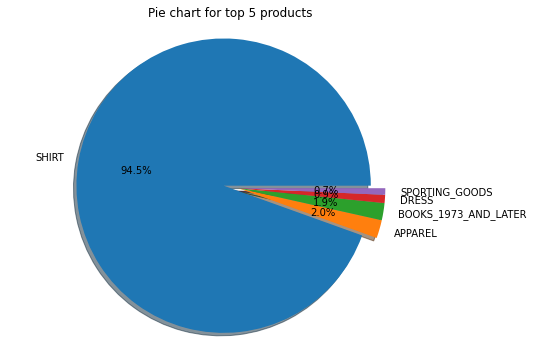

In [7]:
# product_type_name: This tells us about the type of goods
print('The top 5 products available are:')
print(data['product_type_name'].value_counts().head(5))

# Code for pie-chart:
x1 = dict(data['product_type_name'].value_counts().head(5))
product = [] 
for x in x1.keys():
    product.append(x)
count = [] 
for y in x1.values():
    count.append(y)
    
labels = product
sizes = count
explode = (0.1,0,0,0,0)  # explode 1st slice

# Plot
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.title('Pie chart for top 5 products')
plt.show()

In [8]:
data['product_type_name'].describe()

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object

- The unique products are 72 and there is no null value for the product type.
- Shirt corresponds to a whopping 91% of the total items present!

# Color

In [9]:
# color:
x2 = (data['color'].describe())
print(x2)
print('*'*100)
print('{}% of the items have information about the color, rest are (None)'.format(round(x2[0]*100/data.shape[0]),2))
print('*'*100)

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object
****************************************************************************************************
35% of the items have information about the color, rest are (None)
****************************************************************************************************


In [10]:
print('The most common colors present are:')
print('*'*100)
x3 = data['color'].value_counts().head(10)
print(x3)

The most common colors present are:
****************************************************************************************************
Black    13207
White     8616
Blue      3570
Red       2289
Pink      1842
Grey      1499
*         1388
Green     1258
Multi     1203
Gray      1189
Name: color, dtype: int64


In [11]:
# code for bar-plot:
x4 = [y for y in dict(x3).keys()]
x5 = [i for i in dict(x3).values()]
plt.figure(figsize=(15, 4))
plt.bar(x4,x5,width = 0.8)
plt.title('Top 10 colors available')
plt.xlabel('Colors')
plt.ylabel('Counts')
plt.show()

# Brand:

In [12]:
x6 = (data['brand'].describe())
print(x6)
print('*'*100)
print('There are {} missing values in the feature Brand'.format(data.shape[0]-x6[0]))
print('*'*100)
print('The most common brands in the dataset are:')
data['brand'].value_counts().head(7)

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object
****************************************************************************************************
There are 151 missing values in the feature Brand
****************************************************************************************************
The most common brands in the dataset are:


Zago                         223
XQS                          222
Yayun                        215
YUNY                         198
XiaoTianXin-women clothes    193
Generic                      192
Boohoo                       190
Name: brand, dtype: int64

In [13]:
# code for funnel chart:
x7 = data['brand'].value_counts().head(10)
x8 = [y for y in dict(x7).keys()]
x9 = [i for i in dict(x7).values()]
import plotly.express as px
funnel = dict(Count = x9, Brands = x8)
fig = px.funnel(funnel, x='Count', y='Brands')
fig.show()

# Formatted price:

In [14]:
p1 = data['formatted_price'].describe()
print(p1)
print('*'*100)
print('{}% of the items have missing values for the price'.format(100-(round(p1[0]*100/data.shape[0],2))))

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object
****************************************************************************************************
84.5% of the items have missing values for the price


- Most of the people purchase a product by keeping some price in their mind.
- Therefore price being an important feature, we will be dropping all rows having null values for price. 

In [15]:
# Dropping the nan rows for 'price'
data_ = data[data['formatted_price'].notna()]
print('The new dataframe has shape:',data_.shape)
new = data_.reset_index(drop=True) # resetting the index to start from (0)

The new dataframe has shape: (28395, 7)


In [16]:
# Cleaning the price feature for better visualisation

pd.options.mode.chained_assignment = None
v = [x.replace('$','') for x in list(new['formatted_price'].values)] # to replace the '$' sign with empty string
v1 = [y.replace('Too low to display','0') for y in v] # the rows with such string are replaced by (0)
v2 = [z.replace(',','') for z in v1] # Example: (1,299.99)----> (1299.99)
new['formatted_price'] = v2 # adding cleaned feature to the dataframe

In [17]:
# formatted_price feature is of the type (str) so, we have to convert it into float:
new['formatted_price'] = new['formatted_price'].astype(float)

The mean value is: 32.103681634086506
The max value is: 1129.99
The min value is: 0.0
Median: 19.02
Inter Quartile Range: 24.215
****************************************************************************************************


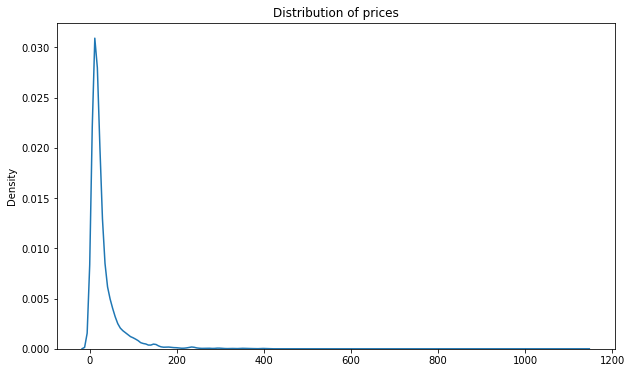

In [18]:
# Visualising the distribution of prices:
plt.figure(figsize=(10, 6))
plt.title('Distribution of prices')
sns.kdeplot(new['formatted_price'].values)
print('The mean value is:',new['formatted_price'].mean())
print('The max value is:',new['formatted_price'].max())
print('The min value is:',new['formatted_price'].min())
print('Median:',np.percentile(new['formatted_price'].values,50))
print('Inter Quartile Range:',round(np.percentile(new['formatted_price'].values,75) - np.percentile(new['formatted_price'].values,25),3))
print('*'*100)
plt.show()

- We see a skewed distribution for the formatted_price feature, it loos like a log normal distribution.
- Also, around 50% of the prices have value around 24.215 (IQR).

# Title:

In [19]:
t1 = new['title'].describe()
t1

count                                                 28395
unique                                                26069
top       FINEJO Casual Women Long Sleeve Lace Irregular...
freq                                                     47
Name: title, dtype: object

In [20]:
print('The top 5 available items have the following titles')
print('*'*100)
print(new['title'].value_counts().head(5))
print('*'*100)

The top 5 available items have the following titles
****************************************************************************************************
FINEJO Casual Women Long Sleeve Lace Irregular Hem Blouse Tops       47
Girlzwalk Women Cami Sleeveless Printed Swing Vest Top Plus Sizes    43
Victoria Scoop Neck Front Lace Floral High-Low Top in 4 Sizes        40
Long Sleeve Mock Neck Top                                            31
Women's FOOTBALL REDBULL Long Sleeve T-Shirt                         30
Name: title, dtype: int64
****************************************************************************************************


- While recommending items we want to show the customer a good variety of products and since we will be using 'title' as the most important feature for recommendation, we will be dropping the titles which are very similar.

# Data Cleaning:

# Title:

In [21]:
# Dropping duplicate titles:
new.drop_duplicates(subset = 'title',keep = False, inplace = True)
print('Shape of dataset after dropping duplicate titles:',new.shape)

Shape of dataset after dropping duplicate titles: (25171, 7)


In [22]:
# Example for title similarity:
s1 = new['title'].values[3]
s2 = new['title'].values[4]
print(s1)
print('*'*100)
print(s2)
print('*'*100)
print('Similarity score:',fuzz.token_sort_ratio(s1,s2))

Supernatural Chibis Sam Dean And Castiel Short Sleeve T Shirts For Lady Purple S
****************************************************************************************************
Supernatural Chibis Sam Dean And Castiel O Neck T-shirts For Female Purple L
****************************************************************************************************
Similarity score: 79


- As we can see, the above two titles differ only in their sizes while describing the product.
- Hence, we get a high score of 79. Therefore, we will be dropping similar titles which give such high score. Here, we keep the first title and drop the subsequent titles.
- If we do not drop similar titles then during recommendation we would be seeing same products again and again.

In [74]:
# Because of low computation power we are randomly selecting 10k rows:
# As it takes more than 3 hours to get rid of the similar titles
new = new.sample(n = 10000)

In [75]:
'''def title(a,b):
    '''
    #This function returns the indexes of rows which are similar to a given row
    #These indexes then help us to remove the similar titles
    
    '''
    idx = [i for i in range(a,b)] 
    remove_title = [] # this stores the indexes of rows to be dropped
    for a in tqdm(idx): # for a given row we compare it to all other rows
        idx.remove(a)
        for b in idx:
            calculate =fuzz.token_sort_ratio(new['title'].values[a],new['title'].values[b])
            if calculate >= 85: # if two titles have high similarity
                remove_title.append(b) # then append the index of that row
                idx.remove(b) # we simultaneously remove the row from the (idx) list to avoid checking similarity again and again
    return remove_title
    
'''

'''new_titles = title(0,new.shape[0])''' # applying the above function

In [84]:
'''new.drop(new.index[new_titles], inplace=True)''' # dropping the rows with high similarity

In [88]:
#print('After dropping similar titles the shape of dataset is:',new.shape)

After dropping similar titles the shape of dataset is: (7910, 7)


- saving this new dataframe:
- new.to_csv('file1.csv')

In [23]:
# Reading the new dataframe:
new_data = pd.read_csv('file1.csv') 
new_data = new_data.iloc[:,1:]
new_data.head(3)

asin     product_type_name  formatted_price        color  \
0  B074QMTX96                 SHIRT            29.99  Light Brown   
1  B071XXFSW9                 SHIRT             3.69     Hot Pink   
2  B01AT4PC9U  BOOKS_1973_AND_LATER             8.00        Black   

          brand                                              title  \
0          Rain                      Women's V-neck casual T-shirt   
1  Best-topshop  Best-topshop Women's Girls Workout Camisole Ro...   
2       Qincent  Qincent Womens Screw Neck Tshirts/Uncw House Logo   

                                    medium_image_url  
0  https://images-na.ssl-images-amazon.com/images...  
1  https://images-na.ssl-images-amazon.com/images...  
2  https://images-na.ssl-images-amazon.com/images...

In [24]:
# Cleaning the titles:
from nltk.stem import WordNetLemmatizer 
lemma = WordNetLemmatizer()
nltk.download('wordnet')

def clean(text):
    '''
    This function returns titles without any special character,stopwords
    and in lowercase
    
    '''
    sent = re.sub('[^a-zA-Z]',' ',text) # replacing all which are not letters with an empty string
    sent = sent.lower()
    sent = sent.split()
    all_stopwords = stopwords.words('english') # stopwords containing all the english words
    final_sent = [lemma.lemmatize(word) for word in sent if not word in set(all_stopwords)] # applying lemmatization on words if they are not stopwords
    final_sent = ' '.join(final_sent) # joining the words to form sentences
    return final_sent

[nltk_data] Downloading package wordnet to C:\Users\PANCHAYAT  SAMITI
[nltk_data]     01\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
corpus = [] # This list contains all the 'çleaned' titles
for i in tqdm(range(0,new_data.shape[0])):
    call = clean(new_data['title'].values[i])
    corpus.append(call)

100%|█████████████████████████████████████████████████████████████████████████████| 7910/7910 [00:19<00:00, 402.12it/s]


In [26]:
# Adding the 'çleaned' titles to dataframe
new_data['title'] = corpus 

# Data Preprocessing:

In [27]:
# Splitting into train & test set for the feature 'title'
train = new_data['title'].values[0:7000]
test = new_data['title'].values[7000:]
print('Train set size:',len(train))
print('Test set size:',len(test))

Train set size: 7000
Test set size: 910


In [28]:
# TF-IDF on feature 'title'
tfidf = TfidfVectorizer(max_features=300)
train_title = tfidf.fit_transform(train)
test_title = tfidf.transform(test)

print('After TF-IDF')
print('Original train data shape',train_title.shape)
print('='*100)
print('Original test data shape',test_title.shape)

After TF-IDF
Original train data shape (7000, 300)
Original test data shape (910, 300)


# Recommendation based on Title Similarity:

In [127]:
def similarity(true,recommend): 
    '''
    This funciton calculates cosine similarity between two titles
    More value(max = 1) means that titles are similar
    Min value(min = 0) means that titles are dissimilar
    
    Given that A & B are two title vectors
    cosine similarity = [dot product(A,B)]/[norm(A)*norm(B)]
    
    true = index of item for whom we want recommendation
    recommend = index of item that we would recommend
    
    '''
    m1 = (train_title.toarray()[true]).reshape(1,-1) # reshaping title vector for dot product
    m2 = (train_title.toarray()[recommend])
    call1 = np.dot(m1,m2) # dot product
    v1 = norm(train_title.toarray()[true]) # norm(A)
    v2 = norm(train_title.toarray()[recommend]) # norm(B)
    return call1/(v1*v2 + 0.001) # cosine similarity

def display_img(idx):
    '''
    Given an index, we fecth the url corresponding to it and display it
    
    '''
    response = requests.get(new_data['medium_image_url'].values[idx])
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(6, 3.5))
    plt.imshow(img)
    
def recommend(given,products):
    '''
    This function calculates cosine similarity, sorts in descending order and through indexes of this 
    descending order we display the number of recommendations(product) we want
    
    '''
    
    iterations = [r for r in range(0,products-1)] # list to keep track of number of products recommended
    sim = np.array([similarity(given,xo) for xo in range(0,7000)]) # calculating similarity
    co = sim.flatten() # converting array of similarity to 1D
    c1 = sorted(co,reverse=True) # sorting the similarity values in descending order
    sim_product_index = [list(co).index(u) for u in c1][1:products] # fetching the indexes of similar values
    for i,j in zip(sim_product_index,iterations): # this loop displays images of our recommendation
        display_img(i)
        print('Recommendation {}'.format(j+1))
        print('ASIN :',new_data['asin'].values[i])
        print('Brand:',new_data['brand'].values[i])
        print('Title:',new_data['title'].values[i])
        print('Similarity value:',co[i])
        print('='*60)

The following is the product that we are currently seeing:
ASIN : B0752Q6BLK
Brand: lily_white
Title: lily white gray woman plaid print button top red x


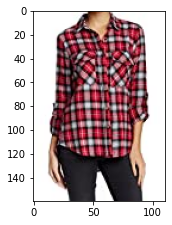

In [129]:
# Checking our recommendation system based on title similarity
given = idx = 250

print('The following is the product that we are currently seeing:')
print('ASIN :',new_data['asin'].values[idx])
print('Brand:',new_data['brand'].values[idx])
print('Title:',new_data['title'].values[idx])
print('='*60)
display_img(idx)


The following are the recommendations for the above product:
Recommendation 1
ASIN : B074PMT9CY
Brand: ruggedbutts
Title: buffalo plaid button red
Similarity value: 0.7276376286902219
Recommendation 2
ASIN : B01LZZHQO4
Brand: painted_threads
Title: painted thread white woman plaid button shirt red x
Similarity value: 0.6230153147131068
Recommendation 3
ASIN : B06XKHQ5P5
Brand: angie
Title: angie woman plaid button shirt l
Similarity value: 0.6163546804407252
Recommendation 4
ASIN : B01K5TFGMM
Brand: allen_b_by_allen_schwartz
Title: allen b plaid print woman large button shirt pink l
Similarity value: 0.6131914967240183
Recommendation 5
ASIN : B01MQNFD44
Brand: jack
Title: jack bb dakota woman euphrasia soft plaid print button back tank top rococo red medium
Similarity value: 0.6119009068498863
Recommendation 6
ASIN : B06XC6VPZ9
Brand: sacred_threads
Title: sacred red gray plaid cotton roll sleeve top career o l
Similarity value: 0.5682725626712909
Recommendation 7
ASIN : B00ZZTXRKQ
Bra

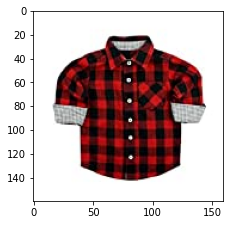

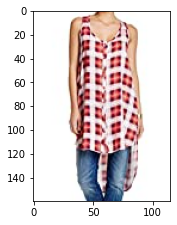

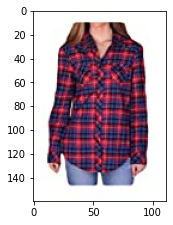

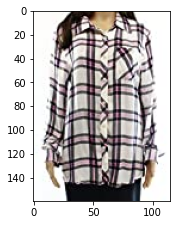

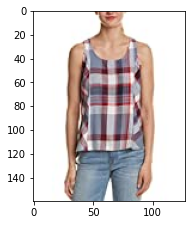

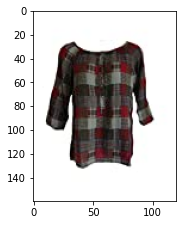

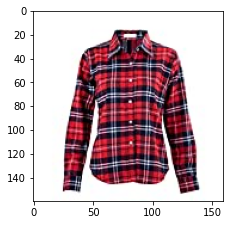

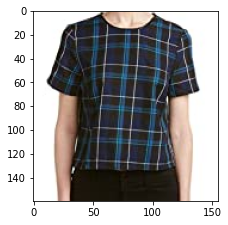

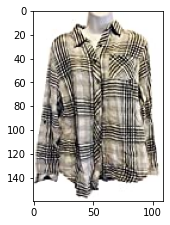

In [130]:
# Recommended products:

start_time = time.time() # keeping an eye on the time it takes to return all our recommendations
products = 10
print('The following are the recommendations for the above product:')
recommend(given,products)
title_sim = (time.time() - start_time)

In [131]:
print('Time taken to get recommendations through Title Similarity',title_sim)

Time taken to get recommendations through Title Similarity 444.5832288265228


# Using Nearest Neighbours algorithm for recommendation:

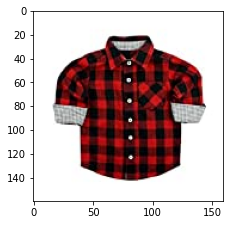

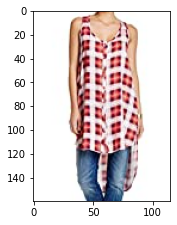

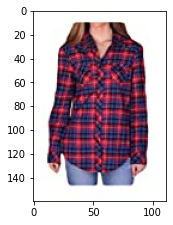

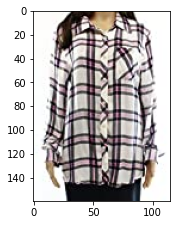

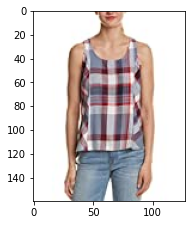

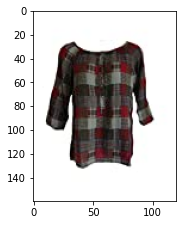

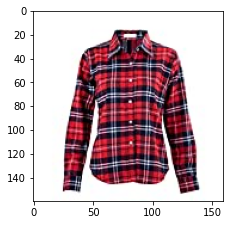

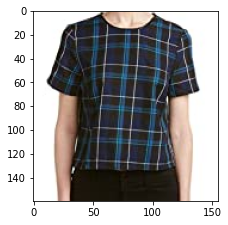

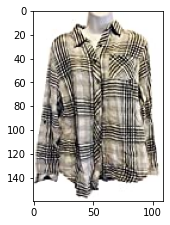

In [132]:
start_time = time.time()
similar_products = NearestNeighbors(n_neighbors=10, algorithm='auto')
similar_products.fit(train_title)
distances, indices = similar_products.kneighbors([train_title.toarray()[250]])

for k in list(indices.flatten())[1:]:
    display_img(k)
model_sim = (time.time() - start_time)

In [133]:
print('Time taken to get recommendations through Nearest Neighbours model',model_sim)

Time taken to get recommendations through Nearest Neighbours model 4.463823080062866


- As we clearly see that the results obtained from title similarity and the model are almost same but the execution is very fast for the model compared to the former one. (4 seconds <<< 444 seconds)
- Therefore, we will be using the Nearest neighbour model only!

# Consider additional features for Nearest Neighbour model:

# Data Cleaning:

In [30]:
# Checking nan values:
idx1 = new_data[new_data.isna().any(axis=1)]
print('The following rows contain nan values:')
idx1

The following rows contain nan values:


asin     product_type_name  formatted_price   color        brand  \
146   B00DTWOA0M  HEALTH_PERSONAL_CARE            25.48   White          NaN   
254   B00ED3542O  HEALTH_PERSONAL_CARE            16.74   Black          NaN   
530   B075317VZB            MISC_OTHER            39.95    gray          NaN   
793   B00NP5Y06M  HEALTH_PERSONAL_CARE            15.41   White          NaN   
1125  B00A2H05EC  HEALTH_PERSONAL_CARE            16.74    Blue          NaN   
1510  B074HCRG27            MISC_OTHER            39.95   multi          NaN   
1585  B00ED34EMK  HEALTH_PERSONAL_CARE            16.74    Blue          NaN   
1854  B00ED35LEA  HEALTH_PERSONAL_CARE            21.23    Gold          NaN   
1949  B00ED35JHY  HEALTH_PERSONAL_CARE            21.23   Black          NaN   
2373  B073XT4NRY            MISC_OTHER            34.95    blue          NaN   
2548  B00JEBDZBM        SPORTING_GOODS            54.99    Pink          NaN   
3311  B008R82LNQ        AUTO_ACCESSORY            41.97     Red          NaN   
3327  B00DTWJQH4  HEALTH_PERSONAL_CARE            28.14    Blue          NaN   
3514  B00A2HFAS8  HEALTH_PERSONAL_CARE            20.65  Purple          NaN   
4069  B00ED34AGK  HEALTH_PERSONAL_CARE            16.74  Purple          NaN   
4233  B00ERJ0ONS                 SHIRT            25.00    Grey          NaN   
4932  B00A2HEADE  HEALTH_PERSONAL_CARE            20.05   Black          NaN   
5114  B00DTWNZKS  HEALTH_PERSONAL_CARE            25.48   Black          NaN   
5251  B00ED34R3Q  HEALTH_PERSONAL_CARE            20.65   Black          NaN   
5298  B00BSX3U64  HEALTH_PERSONAL_CARE            41.19   Beige          NaN   
5597  B074HRPK2X            MISC_OTHER            29.95   cream          NaN   
5674  B00118UDFW        SPORTING_GOODS            24.95   Black          NaN   
6000  B072C95KZ9                 SHIRT            65.95     NaN  Ulla Popken   
6266  B074F2Z31F            MISC_OTHER            39.95   multi          NaN   
6584  B00ED33VBA  HEALTH_PERSONAL_CARE            20.05    Blue          NaN   
7166  B00A2HDF6C  HEALTH_PERSONAL_CARE            20.05    Pink          NaN   
7407  B00DTWO4K8  HEALTH_PERSONAL_CARE            25.48   Brown          NaN   
7674  B00ED35J60  HEALTH_PERSONAL_CARE            21.23    Pink          NaN   
7799  B00ED31NIS  HEALTH_PERSONAL_CARE            20.05  Purple          NaN   

                                                  title  \
146   fossa apparel white l large lady oasis wicking...   
254   pizzazz performance wear hpkblk axl adult race...   
530   nwt sacred thread stonewashed gray embroidered...   
793   proline lady dry wicking v neck polo shirt bla...   
1125  pizzazz performance wear roy adult racer back ...   
1510  sacred thread flamenco patch funky rayon peplu...   
1585  pizzazz performance wear col al adult racer ba...   
1854  pizzazz performance wear gol adult metallic ra...   
1949  pizzazz performance wear blk adult metallic ra...   
2373  nwt sacred thread embroidered light blue rayon...   
2548                                   armour mock pink   
3311                          bmw lady polo red x large   
3327  fossa apparel navy xl x large lady oasis wicki...   
3514  pizzazz performance wear s pur al s adult supe...   
4069  pizzazz performance wear pur al adult racer ba...   
4233  cheerleader gray flyer size small woman cotton...   
4932  pizzazz performance wear zghpkblkyxs zg youth ...   
5114  fossa apparel black small lady oasis wicking p...   
5251  pizzazz performance wear hpkblk y youth panel ...   
5298        juzo mmhg silver bk shrinker cm silicone ii   
5597  nwt john fashion cream lace sequin lined knitt...   
5674              adidas mst polo shirt woman xxl black   
6000  ulla popken woman plus size relaxed fit two to...   
6266  nwt sacred thread peekaboo cold shoulder patch...   
6584  pizzazz performance wear roy yl youth metallic...   
7166  pizzazz performance wear s hpk ym s youth supe...   
7407  fossa appare

# Product type:

- This feature doesn't have null values and is already clean for vectorization.

# Brand:

In [31]:
# If there is a nan value then we are replacing nan with the most frequent value in that feature.

brand = new_data['brand'].isnull().values.any()
if brand == True:
    new_data['brand']=new_data['brand'].fillna('Zago') # Since 'zago' brand occurs most of the time.

In [32]:
# Cleaning the brand feature
brand = []
for i in list(new_data['brand'].values): 
    txt = i.lower()
    txt = re.sub(" ",'_', txt) # replacing an empty space with (_)
    txt = re.sub('\d','',txt) # replacing any numeric value with (empty string)
    txt = re.sub(r'\W','',txt) # replacing anyything which is non-word character with (empty string)
    brand.append(txt)

new_data['brand'] = brand # adding 'cleaned' brands to the dataframe

- Before cleaning: ['SODIAL(R)' ,'Young Fabulous & Broke' ,'Melissa McCarthy Seven7' ,'2(X)IST' ,'Sport-Tek',]
- After Cleaning: ['sodialr' , 'young_fabulous__broke' , 'melissa_mccarthy_seven' , 'xist' , 'sporttek']

# Color:

In [33]:
colors = new_data['color'].isnull().values.any()
if colors == True:
    new_data['color']=new_data['color'].fillna('Black') # Since 'Black' brand occurs most of the time. 

In [34]:
color1 = []
for i in list(new_data['color'].values): 
    txt = i.lower()
    txt = re.sub(" ",'_', txt)
    txt = re.sub('\d','',txt)
    txt = re.sub(r'\W','',txt)
    txt = re.sub('_','',txt)
    color1.append(txt)

new_data['color'] = color1

- Before Cleaning:['Black/White','Pink (Nude)','Heather Grey (90/10)','Zql Blanc/Encrier-navire','Black - Schwarz (Black 001)']
- After Cleaning: ['blackwhite', 'pinknude', 'heathergrey', 'zqlblancencriernavire', 'blackschwarzblack']

# Data Preprocessing:

In [36]:
print('This is how our cleaned dataframe looks:')
new_data.head(2)

This is how our cleaned dataframe looks:


asin product_type_name  formatted_price       color        brand  \
0  B074QMTX96             SHIRT            29.99  lightbrown         rain   
1  B071XXFSW9             SHIRT             3.69     hotpink  besttopshop   

                                               title  \
0                          woman v neck casual shirt   
1  best topshop woman girl workout camisole round...   

                                    medium_image_url  
0  https://images-na.ssl-images-amazon.com/images...  
1  https://images-na.ssl-images-amazon.com/images...

In [37]:
# Train test split:
train_data = new_data.iloc[:7000,:] # 7000 rows for train set
test_data = new_data.iloc[7000:,:] # 910 rows for test set

In [38]:
# One hot encoding for Product type:

ONE1 = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
pt_train = ONE1.fit_transform(train_data['product_type_name'].values.reshape(-1,1))
pt_test = ONE1.transform(test_data['product_type_name'].values.reshape(-1,1))

print('Original train data shape',pt_train.shape)
print('='*100)
print('Original test data shape',pt_test.shape)
print('='*100)

Original train data shape (7000, 38)
Original test data shape (910, 38)


In [40]:
# One hot encoding for Brand:

ONE2 = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
brand_train = ONE2.fit_transform(train_data['brand'].values.reshape(-1,1))
brand_test = ONE2.transform(test_data['brand'].values.reshape(-1,1))

print('Original train data shape',brand_train.shape)
print('='*100)
print('Original test data shape',brand_test.shape)
print('='*100)

Original train data shape (7000, 2186)
Original test data shape (910, 2186)


In [41]:
# One hot encoding for Color:

ONE3 = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
color_train = ONE3.fit_transform(train_data['color'].values.reshape(-1,1))
color_test = ONE3.transform(test_data['color'].values.reshape(-1,1))

print('Original train data shape',color_train.shape)
print('='*100)
print('Original test data shape',color_test.shape)
print('='*100)

Original train data shape (7000, 1709)
Original test data shape (910, 1709)


In [43]:
# Tf-IDF for title:

tfidf = TfidfVectorizer(max_features=300)
title_train = tfidf.fit_transform(train_data['title'].values)
title_test = tfidf.transform(test_data['title'].values)

print('After TF-IDF')
print('Original train data shape',title_train.shape)
print('='*100)
print('Original test data shape',title_test.shape)

After TF-IDF
Original train data shape (7000, 300)
Original test data shape (910, 300)


In [44]:
# Concatenating the features:
X_train = hstack((pt_train,brand_train,color_train,title_train)).tocsr()
X_test = hstack((pt_test,brand_test,color_test,title_test)).tocsr()

print('Final Data Matrix: Training:',X_train.shape)
print('Final Data Matrix: Test:',X_test.shape)

Final Data Matrix: Training: (7000, 4233)
Final Data Matrix: Test: (910, 4233)


# Nearest Neighbour model:

In [80]:
similar_products_model = NearestNeighbors(n_neighbors=10, algorithm='auto')
similar_products_model.fit(X_train)

NearestNeighbors(n_neighbors=10)

The following is the product that we are currently seeing:
ASIN : B00QZZLM24
Brand: bankhunyabangyai_store
Title: nice vintage floral print blouse bky


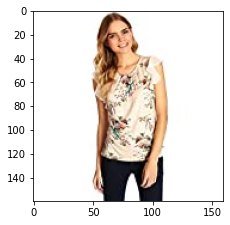

In [140]:
index = 22
distances, indices = similar_products_model.kneighbors([X_test.toarray()[index]])
# distances--> more the distance less the similarity.
# indices--> returns the indices of the nearest neighbours. 
print('The following is the product that we are currently seeing:')
print('ASIN :',new_data['asin'].values[index])
print('Brand:',new_data['brand'].values[index])
print('Title:',new_data['title'].values[index])
print('='*60)
display_img(index)

# 5000 #121 #250

Recommended Items:
ASIN : B00R1FHNPM
Brand: bankhunyabangyai_store
Title: vintage colorful fish long sleeve blouse bky
************************************************************
ASIN : B00QZYGA9A
Brand: bankhunyabangyai_store
Title: good quality chiffon casual shirt floral print bky
************************************************************
ASIN : B00R017820
Brand: bankhunyabangyai_store
Title: fashion plaid print chiffon shirt black white bky
************************************************************
ASIN : B00R09W7CS
Brand: bankhunyabangyai_store
Title: comfortable sexy bird flower print deep v neck chiffon blouse bky
************************************************************
ASIN : B00R05VA9I
Brand: bankhunyabangyai_store
Title: fashion flower print loose ruffle chiffon blouse bky
************************************************************
ASIN : B00Z3U7EA6
Brand: bankhunyabangyai_store
Title: bky summer hot season chiffon blouse green bkyo
*********************************

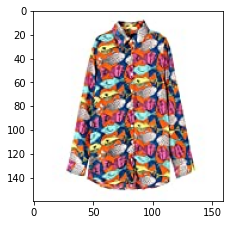

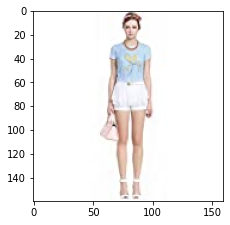

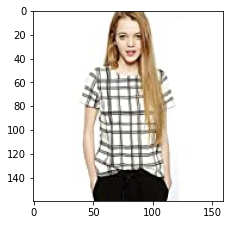

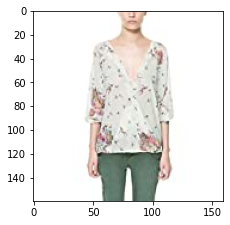

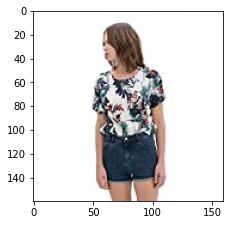

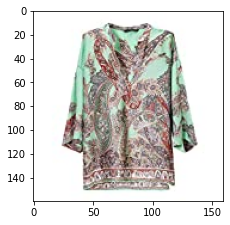

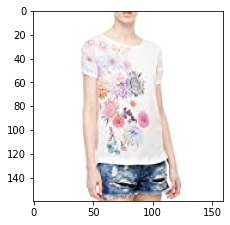

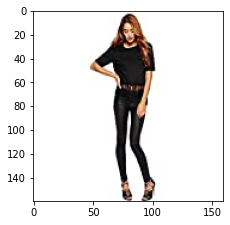

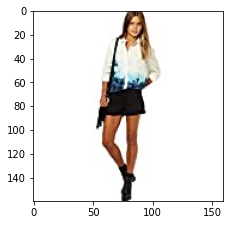

In [141]:
print('Recommended Items:')
for k in list(indices.flatten())[1:]:
    print('ASIN :',new_data['asin'].values[k])
    print('Brand:',new_data['brand'].values[k])
    print('Title:',new_data['title'].values[k])
    print('*'*60)
    display_img(k)

ASIN : B00R1FHNPM
Brand: bankhunyabangyai_store
Title: vintage colorful fish long sleeve blouse bky
************************************************************
ASIN : B00QZZTD0C
Brand: bankhunyabangyai_store
Title: fashion shirt europe american casual vintage floral bky
************************************************************
ASIN : B00QZYGA9A
Brand: bankhunyabangyai_store
Title: good quality chiffon casual shirt floral print bky
************************************************************
ASIN : B010VPD29Y
Brand: bankhunyabangyai_store
Title: bky lace summer black patchwork blouse bky store
************************************************************
ASIN : B00ZD6MLU8
Brand: bankhunyabangyai_store
Title: bky white chiffon casual blouse blue floral bkyo
************************************************************
ASIN : B0738PNF9D
Brand: feianna
Title: feianna woman vintage ethnic bohemia puff sleeve floral top tee blouse v neck
****************************************************

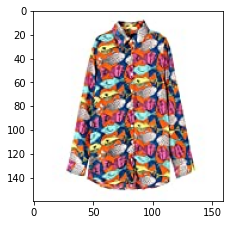

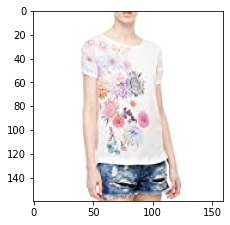

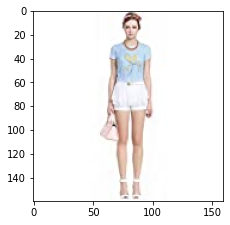

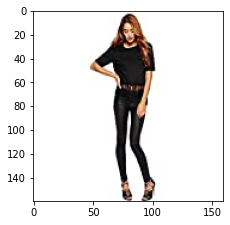

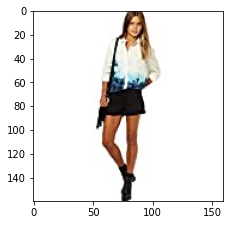

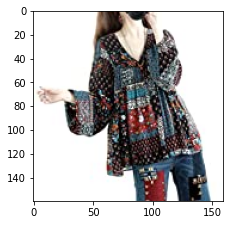

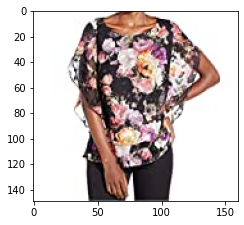

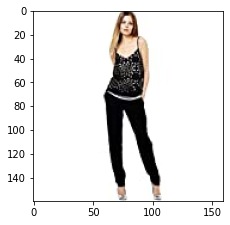

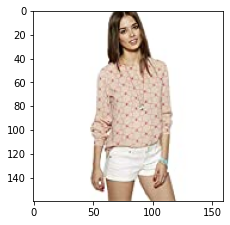

In [142]:
d,i = similar_products.kneighbors([train_title.toarray()[index]])
for p in list(i.flatten())[1:]:
    print('ASIN :',new_data['asin'].values[p])
    print('Brand:',new_data['brand'].values[p])
    print('Title:',new_data['title'].values[p])
    print('*'*60)
    display_img(p)

- As it can be seen, the model with additional features gives much more sensible recommendations than the model with just the title as feature.
- Although in some cases, they both give almost similar recommendations too!

# Code for deployment:

In [144]:
x_tests = test_data.reset_index()

In [152]:
x_tests

index        asin product_type_name  formatted_price            color  \
0     7000  B074LXJQWB             SHIRT            24.99        limegreen   
1     7001  B017VCIYF2             SHIRT            34.50            white   
2     7002  B01N4EHM2L             SHIRT            14.99            black   
3     7003  B00ZSP05ZC             SHIRT            19.50             lime   
4     7004  B01HDKRBW4             SHIRT            14.45             pink   
..     ...         ...               ...              ...              ...   
905   7905  B0721T2KHJ             SHIRT            34.99             navy   
906   7906  B06XDBXHX5             SHIRT            10.99             grey   
907   7907  B0737YZVN1             SHIRT           399.95              red   
908   7908  B0756RJ3GB         ACCESSORY            17.99  blackwhiteapres   
909   7909  B01D1U3228             SHIRT            65.99              tan   

             brand                                              title  \
0            chaps            woman chap lime green polo shirt medium   
1     kenneth_cole  kenneth cole new york woman white aurore foldo...   
2        eye_candy  eye candy junior plus size v neck raglan cap s...   
3     vitamina_usa              vitamina usa laced cropped top l lime   
4          dorathy  dorathy woman fashion cute pug birthday patter...   
..             ...                                                ...   
905   one_teaspoon       one teaspoon woman paisley vintage tank blue   
906   century_star  century star woman fashion pizza print shirt c...   
907      hugo_boss                     bos ilina sheer sleeveless top   
908    worthington  worthington sleeveless knot neck top size pl b...   
909  alice__olivia         alice olivia woman jacinda crop tank brown   

                                      medium_image_url  
0    https://images-na.ssl-images-amazon.com/images...  
1    https://images-na.ssl-images-amazon.com/images...  
2    https://images-na.ssl-images-amazon.com/images...  
3    https://images-na.ssl-images-amazon.com/images...  
4    https://images-na.ssl-images-amazon.com/images...  
..                                                 ...  
905  https://images-na.ssl-images-amazon.com/images...  
906  https://images-na.ssl-images-amazon.com/images...  
907  https://images-na.ssl-images-amazon.com/images...  
908  https://images-na.ssl-images-amazon.com/images...  
909  https://images-na.ssl-images-amazon.com/images...  

[910 rows x 8 columns]

In [146]:
x_tests.shape[0]

910

In [147]:
len(X_test.toarray())

910

In [148]:
# dumping test data for showing color/brand/title:
import pickle
pickle.dump(x_tests.to_dict(),open('test_data.pkl','wb'))

In [162]:
# dumping model:
pickle.dump(similar_products_model,open('model_recommend.pkl','wb'))

In [161]:
# dumping array:
pickle.dump(X_test,open('test_array.pkl','wb'))

In [166]:
# dumping train data for showing images:
pickle.dump(train_data,open('img_data.pkl','wb'))

In [155]:
def display(idx):
    '''
    Given an index, we fecth the url corresponding to it and display it
    
    '''
    response = requests.get(x_tests['medium_image_url'].values[idx])
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(6, 3.5))
    plt.imshow(img)

The following is the product that we are currently seeing:


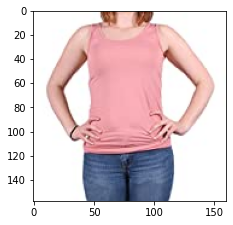

In [163]:
# checking on test data:

index_ = 874
dis,ind = similar_products_model.kneighbors([X_test.toarray()[index_]])
print('The following is the product that we are currently seeing:')
print('='*60)
display(index_) # displaying this image from test set

Recommended Items:


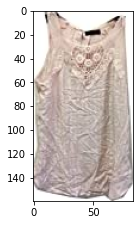

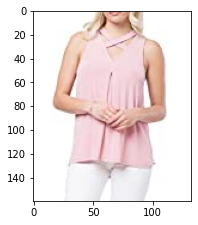

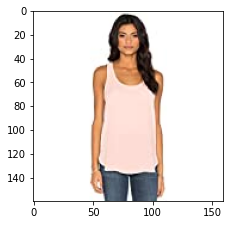

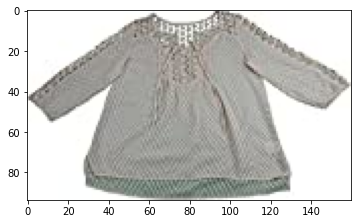

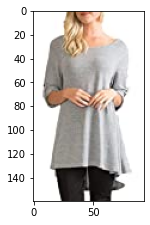

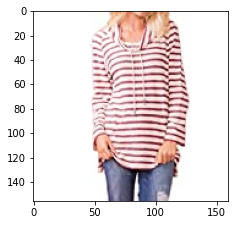

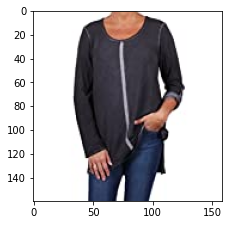

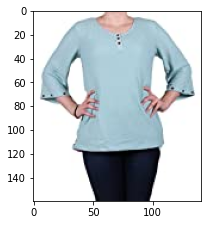

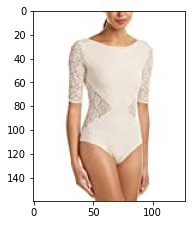

In [164]:
print('Recommended Items:')
for zo in list(ind.flatten())[1:]:
    display_img(zo) # searching images from train set